
# R : SDM : Montane woodcreper
-----------------------

BIO401-01/598-02 
 
Apr. 21 2021


## Preparation
 
    > install.packages("rworldmap")
    > install.packages("maptools")
    > install.packages("rgeos")
    > install.packages("reshape")

In [3]:
library(ggplot2)
library(rworldmap)
library(rgdal)
library(raster)
library(maptools)
library(rgeos)
library(reshape)
library(rasterVis)
library(dismo)
library(InformationValue)
library(mgcv)
library(randomForest)

In [3]:
set.seed(30)

## Data Exploration

We will use Montane woodcreper (Lepidocolaptes lacrymiger) as example species. 

This species has a large range, occurring from the coastal cordillera of Venezuela along the Andes south to south-east Peru and central Bolivia.

<img src='../images/Montane_Woodcreeper.jpg' width="400">

### Read in points data 

In [4]:
birdrange <- readOGR("./geodata/shp", "cartodb-query")

OGR data source with driver: ESRI Shapefile 
Source: "/media/sf_Shared/my_SE_data/exercise/geodata/shp", layer: "cartodb-query"
with 2 features
It has 7 fields


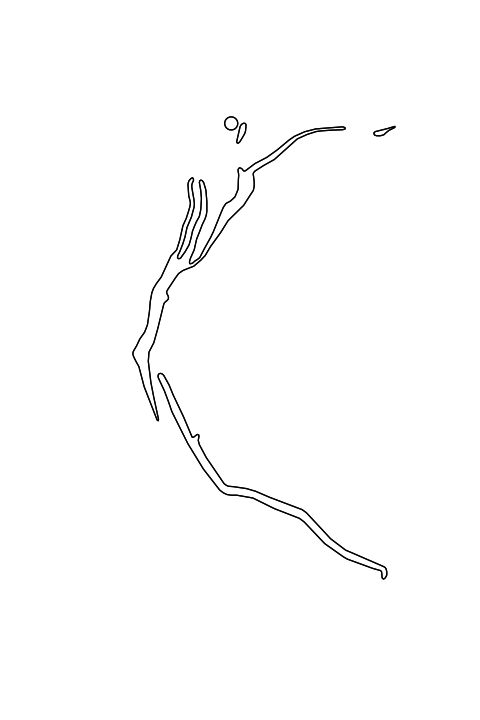

In [7]:
options(repr.plot.width=4, repr.plot.height=6)
plot(birdrange)

In [5]:
 points <- read.csv("./geodata/shp/Lepidocolaptes_lacrymiger_allpoints.csv")
 head(points)

lon,lat,scientific_name
-76.18925,3.98125,Lepidocolaptes_lacrymiger
-76.18406,3.93442,Lepidocolaptes_lacrymiger
-74.30256,4.60675,Lepidocolaptes_lacrymiger
-74.30256,4.60675,Lepidocolaptes_lacrymiger
-76.10394,4.74631,Lepidocolaptes_lacrymiger
-76.13861,4.74536,Lepidocolaptes_lacrymiger


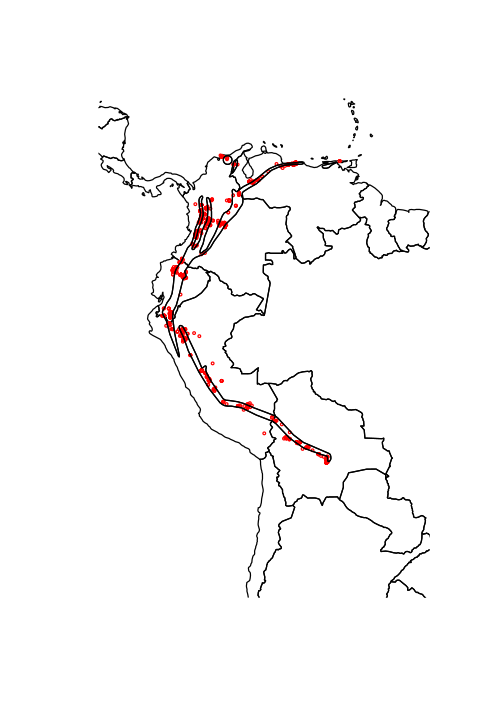

In [9]:
mapSA <- getMap(resolution = "low")
plot(mapSA, xlim = c(-80, -60), ylim = c(-30, 15), asp = 1)
points(points$lon, points$lat, col = "red", cex = .3)
plot(birdrange,add=TRUE)

In [10]:
# indicate that these data are presences
presence <- matrix(1,nrow(points),1)
points <- cbind(points,presence)

In [11]:
head(points)

,lon,lat,scientific_name,presence
,<dbl>,<dbl>,<chr>,<dbl>
1,-76.18925,3.98125,Lepidocolaptes_lacrymiger,1
2,-76.18406,3.93442,Lepidocolaptes_lacrymiger,1
3,-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
4,-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
5,-76.10394,4.74631,Lepidocolaptes_lacrymiger,1
6,-76.13861,4.74536,Lepidocolaptes_lacrymiger,1


In [12]:
# building spatial dataframe
points <- SpatialPointsDataFrame(points[,c(1,2)], points)

In [13]:
# assign projection
projection(points) <- "+proj=longlat +datum=WGS84" 

In [14]:
head(points)

,lon,lat,scientific_name,presence
,<dbl>,<dbl>,<chr>,<dbl>
1,-76.18925,3.98125,Lepidocolaptes_lacrymiger,1
2,-76.18406,3.93442,Lepidocolaptes_lacrymiger,1
3,-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
4,-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
5,-76.10394,4.74631,Lepidocolaptes_lacrymiger,1
6,-76.13861,4.74536,Lepidocolaptes_lacrymiger,1


Loading eBird sampling dataset, in order to obtain “absence” data

In [15]:
# link to global sampling raster
gsampling <- raster("./geodata/SDM/eBirdSampling_filtered.tif")

In [16]:
# crop to species range to create modelling domain
sampling <- crop(gsampling,birdrange)   

In [17]:
# assign projection
projection(sampling)="+proj=longlat +datum=WGS84"

In [18]:
# convert to points within data region
samplingp <- as(sampling,"SpatialPointsDataFrame")

In [19]:
samplingp <- samplingp[samplingp$eBirdSampling_filtered>0,]

In [20]:
head(samplingp@data)

,eBirdSampling_filtered
,<dbl>
687,2
783,1
785,1
786,1
1241,2
2710,4


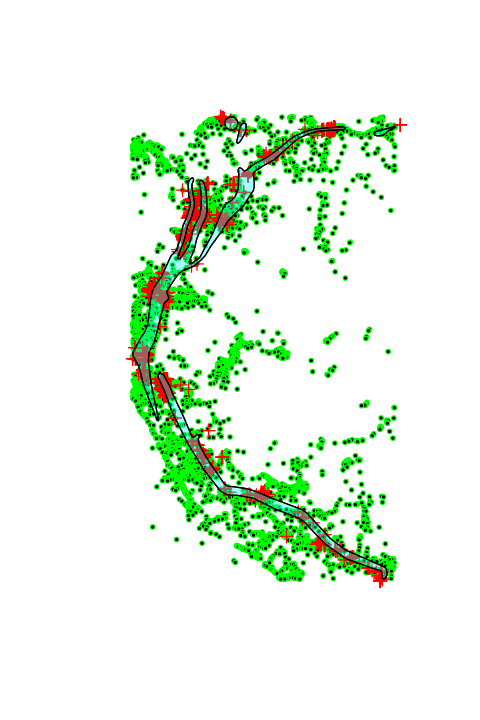

In [21]:
 # edit column names
 colnames(samplingp@data) <- c("observation")
 samplingp$presence=0
 plot(samplingp, col="green",pch=21,cex=.5)#absences
 plot(points, col="red",add=TRUE)#presences
 plot(birdrange, col=alpha("cyan",0.2),add=TRUE)#species range

In [22]:
head(samplingp)

,observation,presence
,<dbl>,<dbl>
687,2,0
783,1,0
785,1,0
786,1,0
1241,2,0
2710,4,0


combine presence and non-presence point datasets

In [43]:
pdata <- rbind(points[,"presence"],samplingp[,"presence"])
pdata@data[,c("lon","lat")] <- coordinates(pdata)
table(pdata$presence)


    0     1 
13188  3438 

In [47]:
head(pdata@data)

,presence,lon,lat
,<dbl>,<dbl>,<dbl>
1,1,-76.18925,3.98125
2,1,-76.18406,3.93442
3,1,-74.30256,4.60675
4,1,-74.30256,4.60675
5,1,-76.10394,4.74631
6,1,-76.13861,4.74536


### Read the environmental data layers

In [6]:
rCld <- raster("./geodata/cloud/SA_meanannual.tif")
rCldIA <-  raster("./geodata/cloud/SA_intra.tif")
rElv <- raster("./geodata/dem/SA_elevation_mn_GMTED2010_mn.tif")
rVeg <- raster("./geodata/vegetation/SA_tree_mn_percentage_GFC2013.tif")

In [7]:
rVeg

class      : RasterLayer 
dimensions : 8400, 5880, 49392000  (nrow, ncol, ncell)
resolution : 0.008333333, 0.008333333  (x, y)
extent     : -83, -34, -56, 14  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : /media/sf_Shared/my_SE_data/exercise/geodata/vegetation/SA_tree_mn_percentage_GFC2013.tif 
names      : SA_tree_mn_percentage_GFC2013 
values     : 0, 65535  (min, max)


In [30]:
region <- as(extent(-83,-60,-25,14), 'SpatialPolygons')
rCld <- crop(rCld, region)
rCldIA <- crop(rCldIA, region)
rElv <- crop(rElv, region)
rVeg <- crop(rVeg, region)

In [31]:
rElv[rElv < 1e-12 ] <- NA 
rCld <- mask(rCld, rElv) 
rCldIA <- mask(rCldIA, rElv) 
rVeg <- mask(rVeg, rElv)

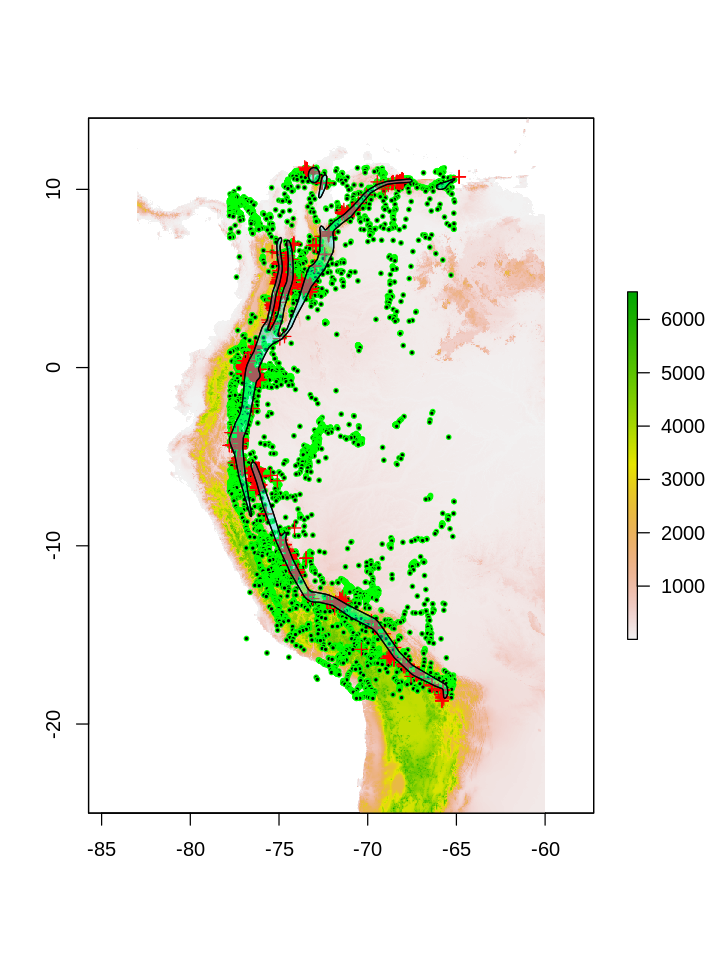

In [33]:
options(repr.plot.width=6, repr.plot.height=8)
plot(rElv)
plot(samplingp, col="green",pch=21,cex=.5,add=TRUE)#absences
plot(points, col="red",add=TRUE)#presences
plot(birdrange, col=alpha("cyan",0.2),add=TRUE)#species range

In [34]:
env <- stack(c(rCld,rCldIA,rElv,rVeg))
env

class      : RasterStack 
dimensions : 4680, 2760, 12916800, 4  (nrow, ncol, ncell, nlayers)
resolution : 0.008333333, 0.008333333  (x, y)
extent     : -83, -60, -25, 14  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      : SA_meanannual, SA_intra, SA_elevation_mn_GMTED2010_mn, SA_tree_mn_percentage_GFC2013 
min values :           329,        0,                            1,                             0 
max values :         10000,     3790,                         6517,                         10000 


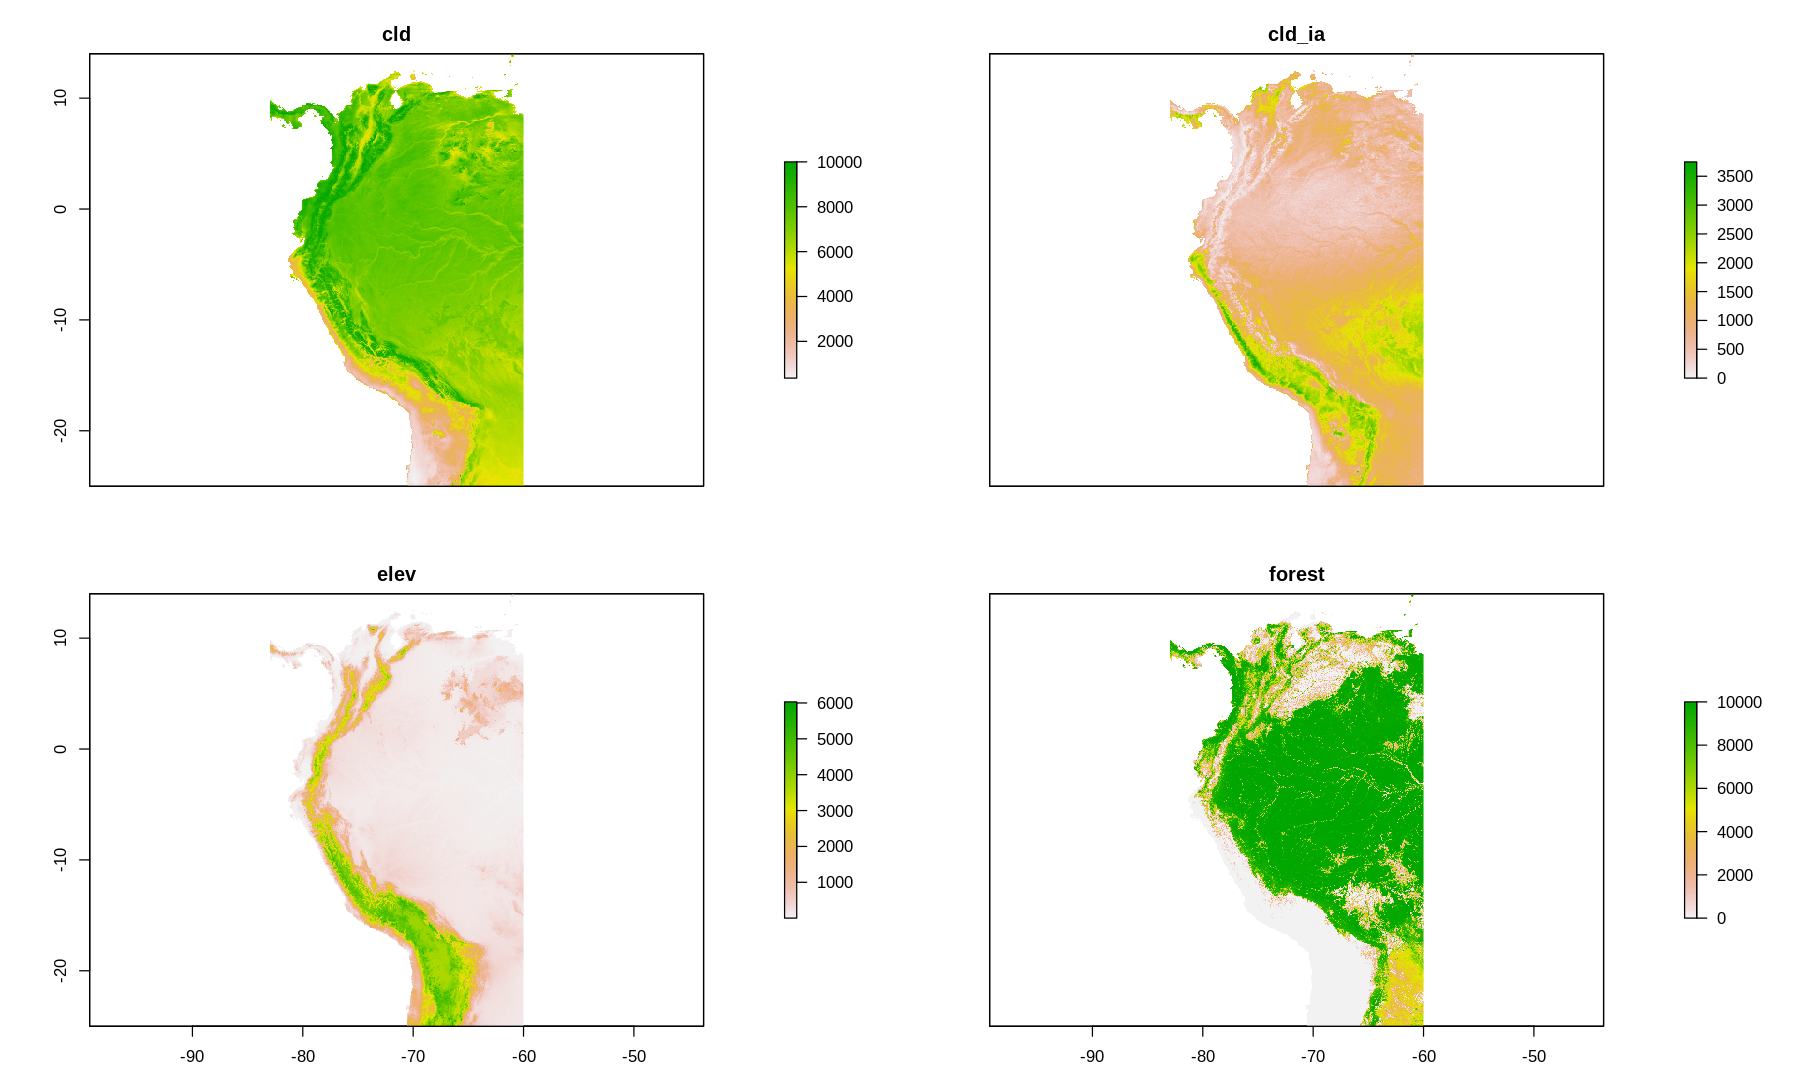

In [35]:
# rename layers for convenience
vars <- c("cld","cld_ia","elev","forest")

names(env) <- vars
 
# visual result 
options(repr.plot.width=15, repr.plot.height=9)
 # check out the plot
plot(env)

Scaling and centering the environmental variables to zero mean and variance of 1

In [36]:
senv <- scale(env[[vars]])

Annotate the point records with the scaled environmental data

In [48]:
df.xact <- raster::extract(senv,pdata,sp=T) 

In [49]:
df.xact <- (df.xact[! is.na(df.xact$forest),])

In [39]:
class(df.xact)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

In [51]:
head(df.xact@data)

,presence,lon,lat,cld,cld_ia,elev,forest
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,-76.18925,3.98125,1.2394701,-1.377718,0.3662724,-0.09381269
2,1,-76.18406,3.93442,1.5096232,-1.387785,0.6391255,0.45338521
3,1,-74.30256,4.60675,1.7659069,-1.609250,1.4263871,0.12390015
4,1,-74.30256,4.60675,1.7659069,-1.609250,1.4263871,0.12390015
5,1,-76.10394,4.74631,0.7829837,-1.094177,0.7290066,0.59139960
6,1,-76.13861,4.74536,1.0477096,-1.240142,0.7603044,0.21331793


### Correlation plots

In [52]:
## convert to 'long' format for easier plotting
df.xactl <- reshape::melt(df.xact@data,id.vars=c("lat","lon","presence"),variable.name="variable")

In [57]:
head(df.xactl)

,lat,lon,presence,variable,value
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,3.98125,-76.18925,1,cld,1.2394701
2,3.93442,-76.18406,1,cld,1.5096232
3,4.60675,-74.30256,1,cld,1.7659069
4,4.60675,-74.30256,1,cld,1.7659069
5,4.74631,-76.10394,1,cld,0.7829837
6,4.74536,-76.13861,1,cld,1.0477096


In [72]:
tail(df.xactl)

,lat,lon,presence,variable,value
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
65451,-18.54583,-63.94583,0,forest,-0.5890122
65452,-18.55416,-70.32917,0,forest,-1.5806262
65453,-18.55416,-70.10417,0,forest,-1.5806262
65454,-18.55416,-70.09583,0,forest,-1.5806262
65455,-18.55416,-63.98750,0,forest,-0.6900932
65456,-18.56249,-69.11250,0,forest,-1.5794113


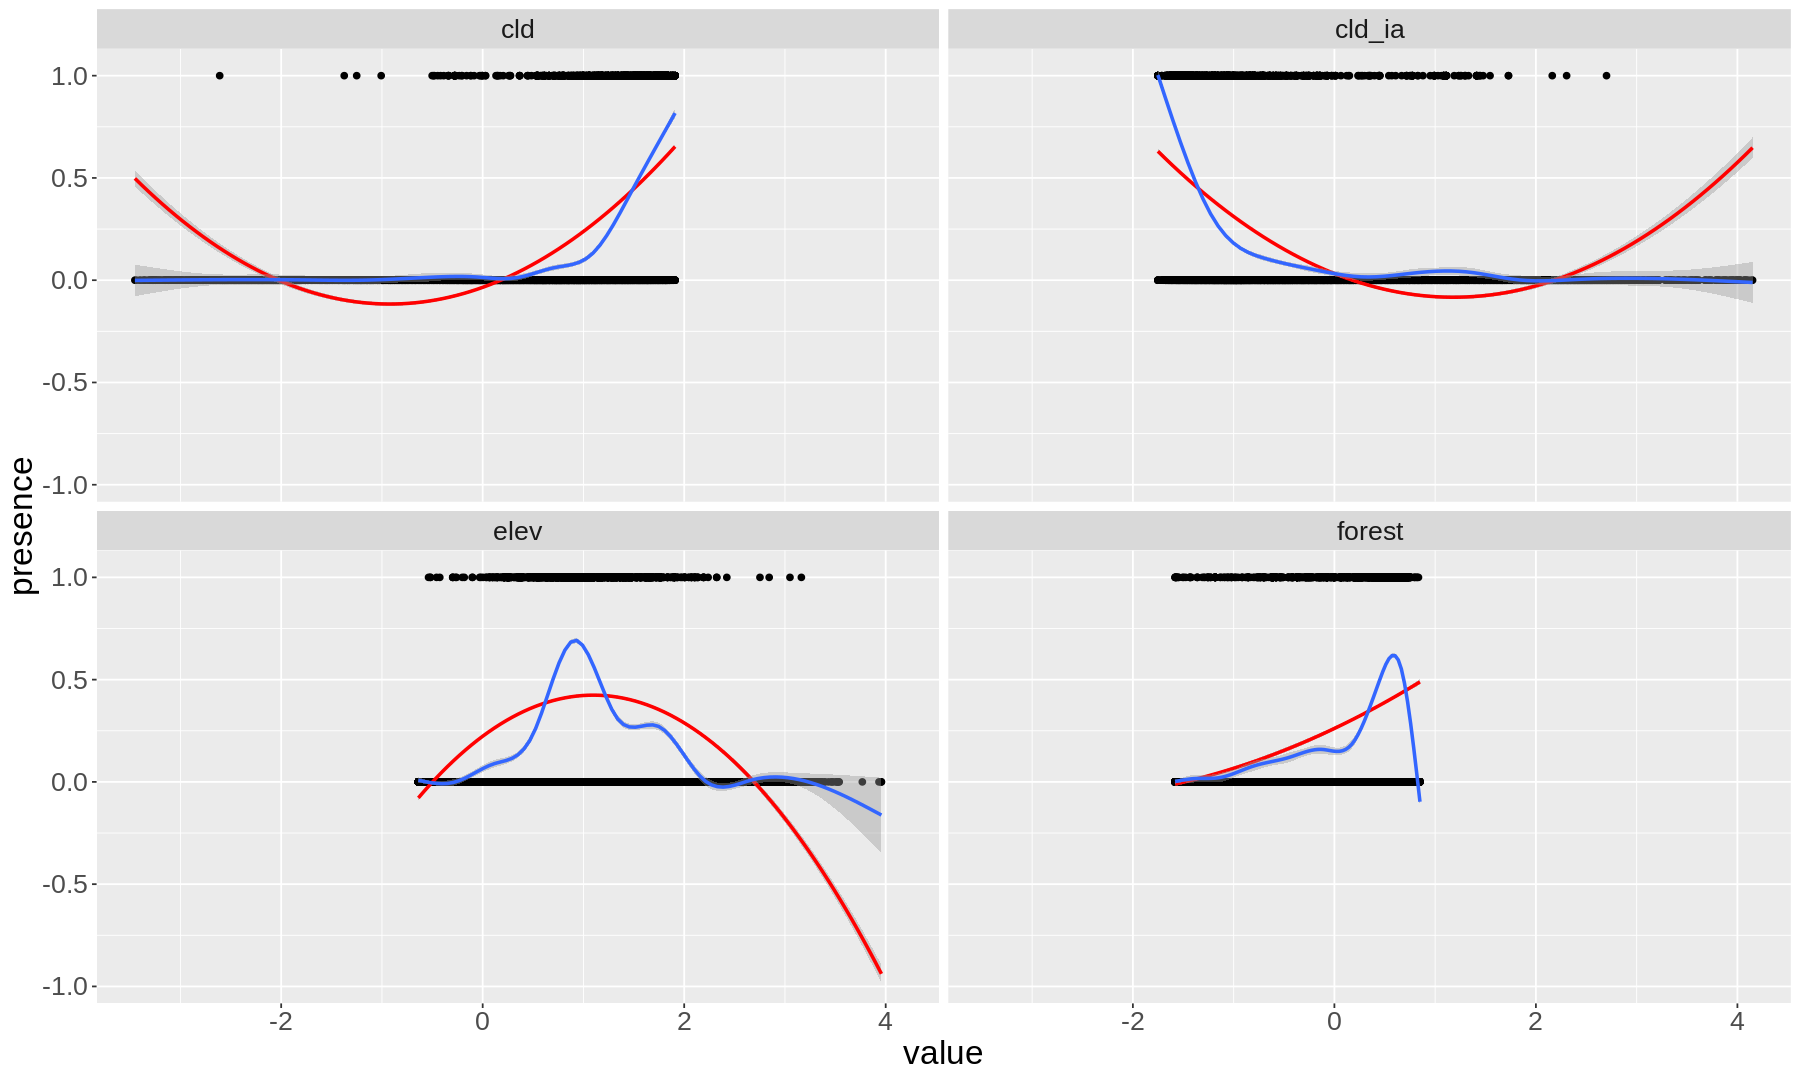

In [55]:
ggplot(df.xactl,aes(x=value,y=presence))+facet_wrap(~variable)+
  geom_point()+
  stat_smooth(method = "lm", formula = y ~ x + I(x^2), col="red")+
  geom_smooth(method="gam",formula=y ~ s(x, bs = "cs")) + 
  theme(text = element_text(size = 20))  

### Model Training and Validation 

- internal validation : validation using the training data 
- external validation : validation with unexposed data 


In [98]:
df.xact <- as.data.frame(df.xact)

In [58]:
df.xact@data$grp <- kfold(df.xact@data,2)

In [59]:
head(df.xact)

,presence,lon,lat,cld,cld_ia,elev,forest,grp
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1,-76.18925,3.98125,1.2394701,-1.377718,0.3662724,-0.09381269,2
2,1,-76.18406,3.93442,1.5096232,-1.387785,0.6391255,0.45338521,1
3,1,-74.30256,4.60675,1.7659069,-1.609250,1.4263871,0.12390015,2
4,1,-74.30256,4.60675,1.7659069,-1.609250,1.4263871,0.12390015,2
5,1,-76.10394,4.74631,0.7829837,-1.094177,0.7290066,0.59139960,2
6,1,-76.13861,4.74536,1.0477096,-1.240142,0.7603044,0.21331793,1


In [140]:
system.time(mdl.glm <- glm(presence~cld+elev*I(elev^2)+forest, family=binomial(link=logit), data=subset(df.xact@data,grp==1)))

   user  system elapsed 
   0.03    0.00    0.03 

In [141]:
summary(mdl.glm)


Call:
glm(formula = presence ~ cld + elev * I(elev^2) + forest, family = binomial(link = logit), 
    data = subset(df.xact@data, grp == 1))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9645  -0.2232  -0.0211  -0.0009   4.4054  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -5.22785    0.21729 -24.060  < 2e-16 ***
cld             1.49829    0.11300  13.260  < 2e-16 ***
elev            6.66699    0.56913  11.714  < 2e-16 ***
I(elev^2)      -4.06156    0.57134  -7.109 1.17e-12 ***
forest          1.46461    0.08687  16.860  < 2e-16 ***
elev:I(elev^2)  0.57395    0.17421   3.295 0.000986 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 8404.5  on 8181  degrees of freedom
Residual deviance: 3878.8  on 8176  degrees of freedom
AIC: 3890.8

Number of Fisher Scoring iterations: 9


### Prediction

Calculate estimates of p(occurrence) for each cell.
We can use the predict function in the raster package to make the predictions across the full raster grid and save the output.

In [71]:
head(df.xact[which(df.xact@data$grp==1),vars])

,cld,cld_ia,elev,forest
,<dbl>,<dbl>,<dbl>,<dbl>
2,1.509623,-1.387785,0.6391255,0.4533852
6,1.047710,-1.240142,0.7603044,0.2133179
7,1.047710,-1.240142,0.7603044,0.2133179
8,1.064594,-1.126054,0.7651195,0.3885087
9,1.729123,-1.431407,0.7001162,0.7308719
11,1.651333,-1.402885,0.2852189,0.4013868


In [77]:
pred.glm.train <- predict(mdl.glm,subset(df.xact@data,grp==1)[vars],type="response")
pred.glm.test <- predict(mdl.glm,subset(df.xact@data,grp==2)[vars],type="response")

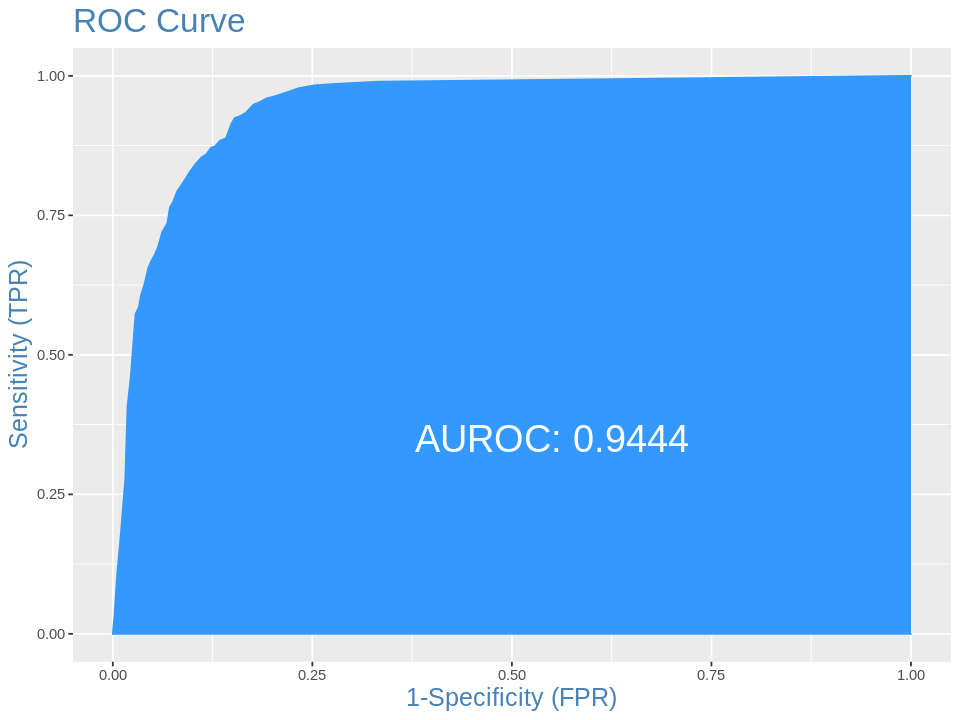

In [92]:
options(repr.plot.width=8, repr.plot.height=6)
plotROC(subset(df.xact@data,grp==1)["presence"],pred.glm.train)

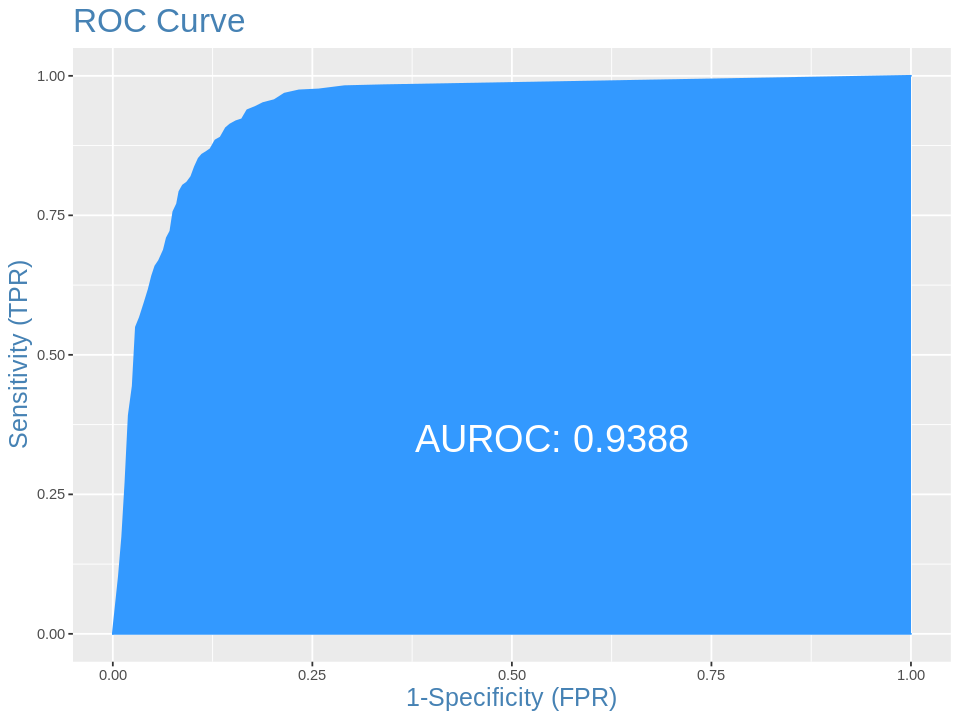

In [93]:
plotROC(subset(df.xact@data,grp==2)["presence"],pred.glm.test)

### Out mapping

In [80]:
pmap <- raster::predict(senv,mdl.glm,type="response")

Plot the results as a map:

Regions defined for each Polygons



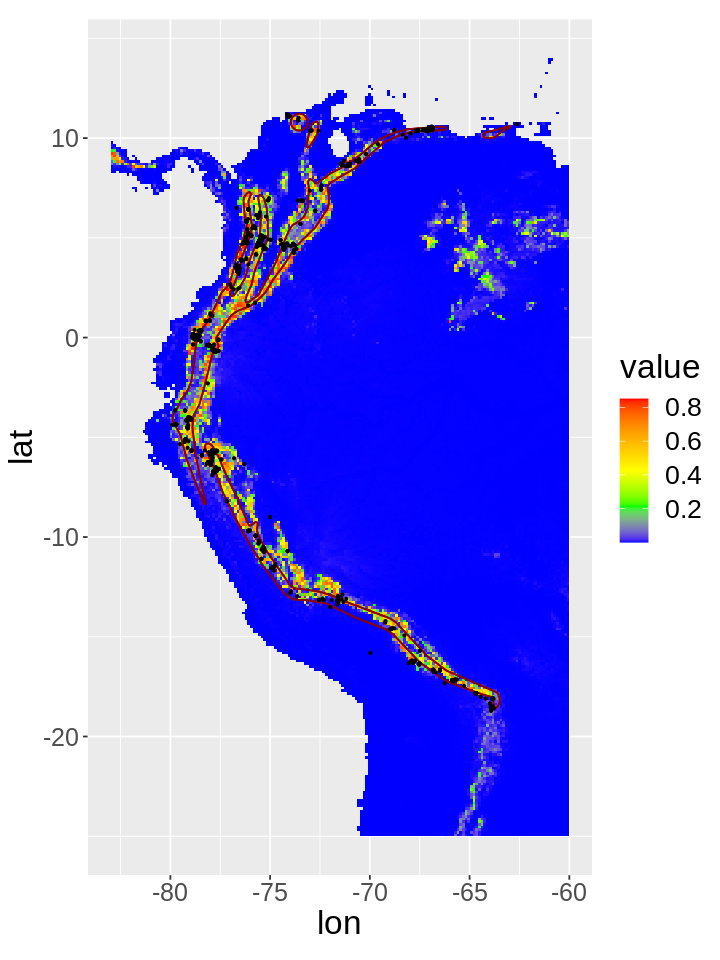

In [88]:
options(repr.plot.width=6, repr.plot.height=8)
gplot(pmap)+geom_tile(aes(fill=value))+
  scale_fill_gradientn(
    colours=c("blue","green","yellow","orange","red"),
    na.value = "transparent")+
  geom_polygon(aes(x=long,y=lat,group=group),
               data=fortify(birdrange),fill="transparent",col="darkred")+
  geom_point(aes(x = lon, y = lat), data = subset(df.xact@data,presence==1),col="black",size=0.5)+
  xlab("lon") + ylab("lat") +
  theme(text = element_text(size=20),
        axis.text.x = element_text(size=15), 
        axis.text.y = element_text(size=15)) +
  coord_equal()

### Model Comparison

- performance 
- efficiency
- parsimony 
- robustness
- scalability 

In [94]:
system.time(mdl.rf <- randomForest(as.factor(presence) ~ cld +cld_ia +elev +forest,data=subset(df.xact@data,grp==1),importance=TRUE))

   user  system elapsed 
  2.806   0.098   2.912 

In [95]:
table(subset(df.xact,grp==1)$presence)


   0    1 
6466 1716 

In [96]:
mdl.rf


Call:
 randomForest(formula = as.factor(presence) ~ cld + cld_ia + elev +      forest, data = subset(df.xact@data, grp == 1), importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 6.99%
Confusion matrix:
     0    1 class.error
0 6184  282  0.04361274
1  290 1426  0.16899767

In [97]:
mdl.rf$importance

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
cld,0.020546965,0.5054900,0.1222723,864.7319
cld_ia,0.005703808,0.3683806,0.0818138,616.5483
elev,0.013127108,0.5035859,0.1160398,534.4906
forest,0.015509632,0.4617944,0.1091712,529.6399


In [98]:
mdl.rf$importance[,1:3]/mdl.rf$importanceSD[,1:3]

,0,1,MeanDecreaseAccuracy
cld,14.02102,106.59001,85.80859
cld_ia,7.25995,62.45445,71.41106
elev,19.47059,182.34508,159.37656
forest,17.06514,169.57906,126.46578


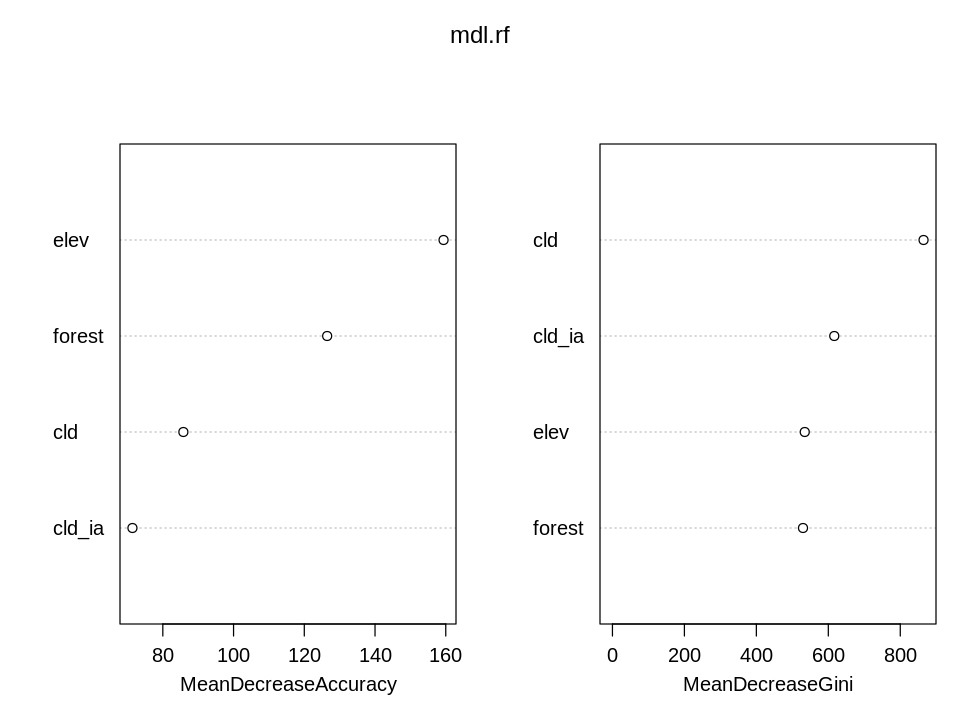

In [99]:
varImpPlot(mdl.rf)

### Variable Importance

- Gini index 

$$i(\tau) = 1 - p_0^2 - p_1^2$$
$$\Delta i(\tau) = i(\tau) - p_l\,i(\tau_l) - p_r\,i(\tau_r)$$

- Variable Permutation

In [112]:
pred.rf.train <- predict(mdl.rf,subset(df.xact@data,grp==1)[vars],type="prob")
pred.rf.train.resp <- predict(mdl.rf,subset(df.xact@data,grp==1)[vars],type="response")

In [113]:
pred.rf.train <- as.data.frame(pred.rf.train)
pred.rf.train$pres <- pred.rf.train.resp

In [149]:
head(pred.rf.train)

,0,1,pres
,<dbl>,<dbl>,<fct>
2,0.248,0.752,1
6,0.088,0.912,1
7,0.088,0.912,1
8,0.280,0.720,1
9,0.218,0.782,1
11,0.528,0.472,0


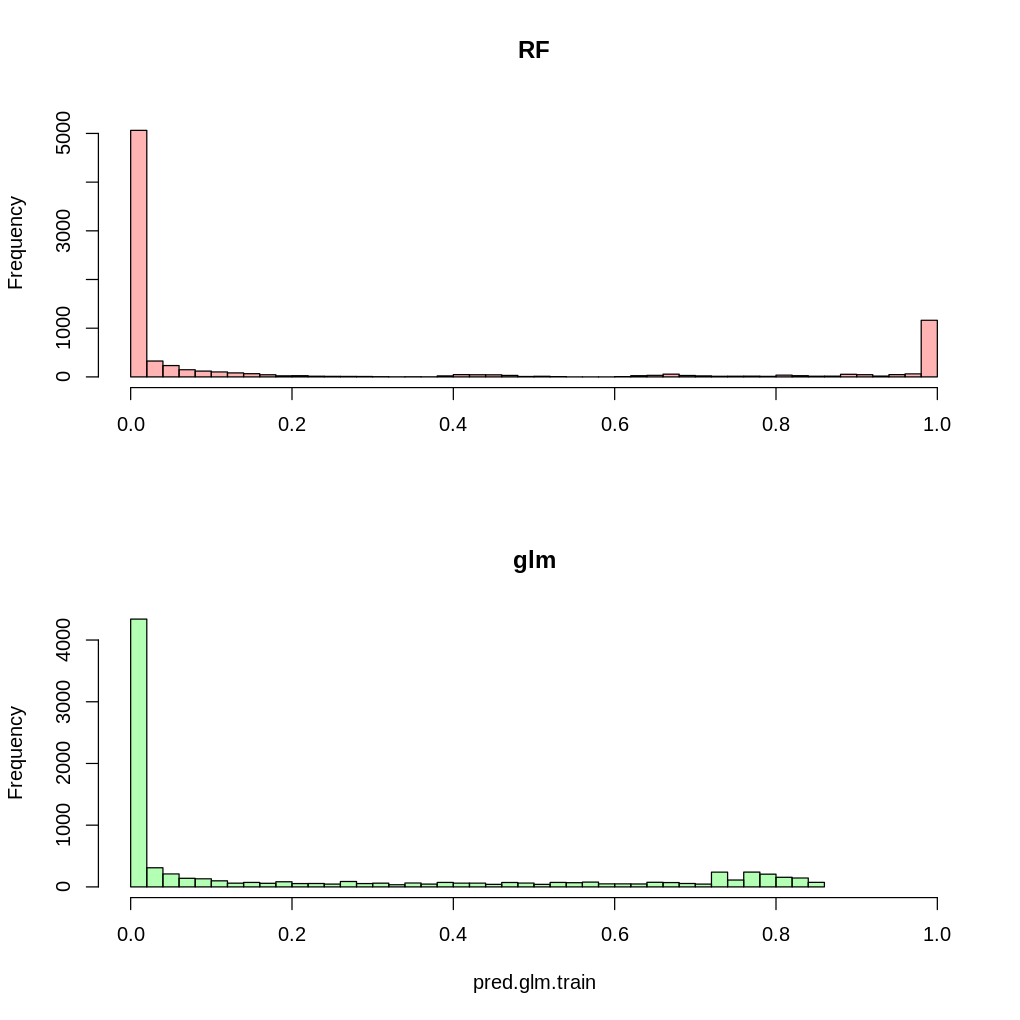

In [137]:
par(mfrow=2:1)
hist(pred.rf.train[,2],breaks=50, main="RF",xlab="",col=alpha("red",0.3),ylim=c(0,5500))
hist(pred.glm.train,breaks=50,main="glm",col=alpha("green",0.3),xlim=c(0,1))

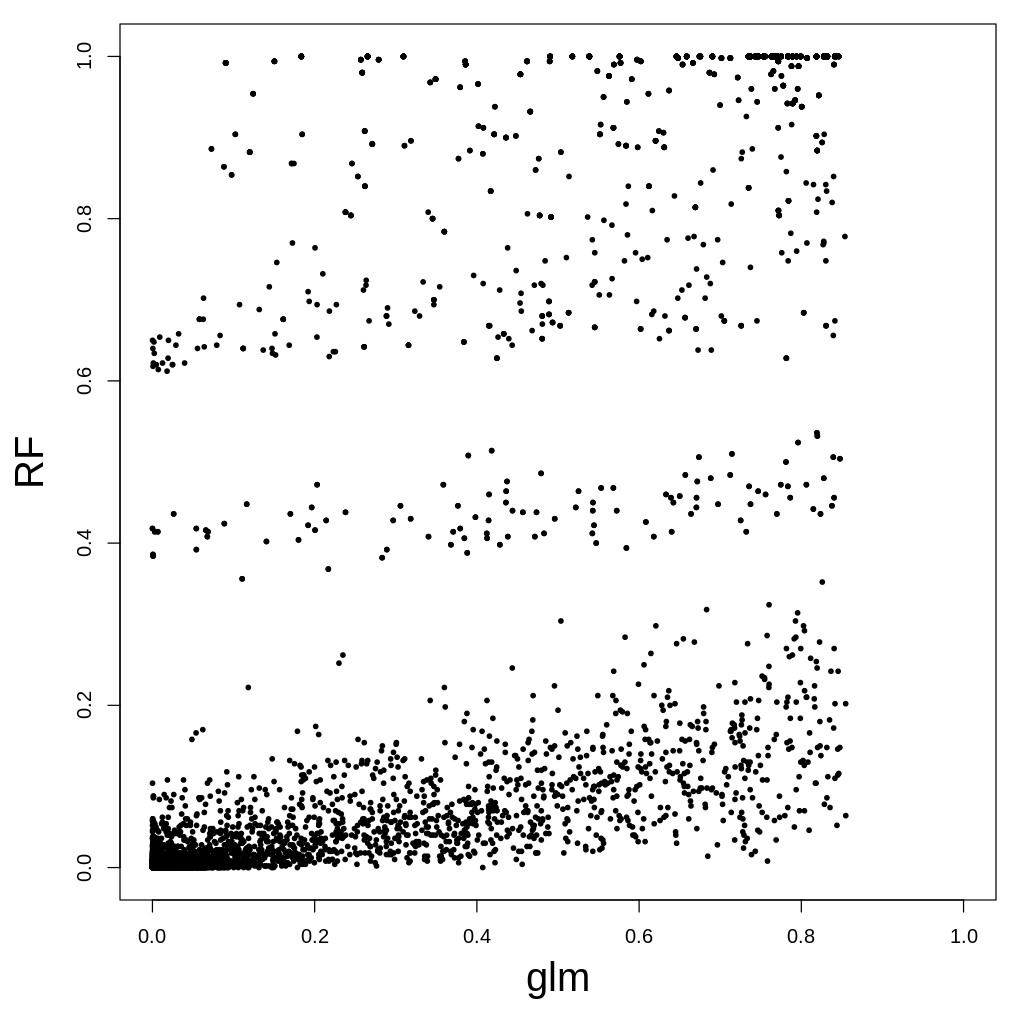

In [136]:
options(repr.plot.width=8.5, repr.plot.height=8.5)
par(mar=c(5,5,1,1))
plot(pred.glm.train,pred.rf.train[,2],cex.lab=2,cex=0.5,xlab = "glm", ylab = "RF", pch = 19, xlim=c(0,1))

## References

- https://en.wikipedia.org/wiki/Cross-validation
- https://en.wikipedia.org/wiki/Time_(Unix)#User_Time_vs_System_Time
- https://en.wikipedia.org/wiki/Random_forest
- https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity
- https://en.wikipedia.org/wiki/Generalized_linear_model
- https://en.wikipedia.org/wiki/Robustness_(computer_science)
- Strobl et. al. BCM. Bioinfo (2007) 8, 25
- Strobl et. al. Comput. Stat. Data Anal. (2007) 52, 483
- Strobl. et. al. BCM. Bioinfo (2008) 9, 307

## Poll 

1. Model anatomy : GLM, RF, etc.   
2. Sampling : sampling design, eg. presence vs. absence
3. Data transformation : such as PCA 
4. Statistic : model evaluation metrics 
5. Scaling  
6. Uncertainty 
7. Graphics : ggplot2 
8. Continue working on your projects 
9. Others? 

<div class="alert alert-block alert-info">
<b>Feedback :  Please provide input via slack channel by 4pm Apr 22. (EDT) </b>
</div>